In [1]:
from pathlib import Path
import sys
import os

root = Path.cwd().parent
sys.path.append(str(root))

In [2]:
from src.config import config

config = config.get('cluster', {})

SEED = 42

In [3]:
import pandas as pd
import numpy as np
import ast

df = pd.read_csv(root / "data" / "bsc_dataset_regplans" / "embedded_icl_examples_1536d.csv")
df['embedding'] = df['embedding'].apply(ast.literal_eval).apply(np.array)

In [4]:
embeddings = np.vstack(df['embedding'].values)

In [5]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=SEED)

embeddings_tsne = tsne.fit_transform(embeddings)

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import umap

umap_reducer = umap.UMAP(n_components=30, random_state=SEED)

embeddings_umap = umap_reducer.fit_transform(embeddings)

### HDBSCAN Parameters

https://hdbscan.readthedocs.io/en/latest/parameter_selection.html#

- `min_cluster_size` should be set to the smallest size grouping one wish to consider a cluster.

- `min_samples` if unspecified follows `min_cluster_size`, but if set it essentially provide a measure of how conservative one want the clustering to be.

- `cluster_selection_epsilon` is nice because it allows me to set a small `min_cluster_size` becasue groups of few points are important. The param sets a threshold so that clusters below it are not split up any further.

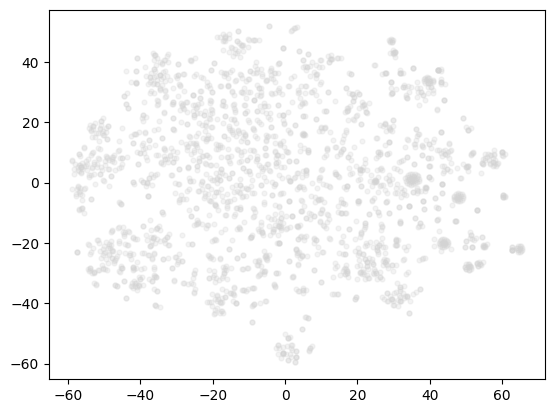

In [8]:
import matplotlib.pyplot as plt

plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c="lightgrey", alpha=0.25, s=12);

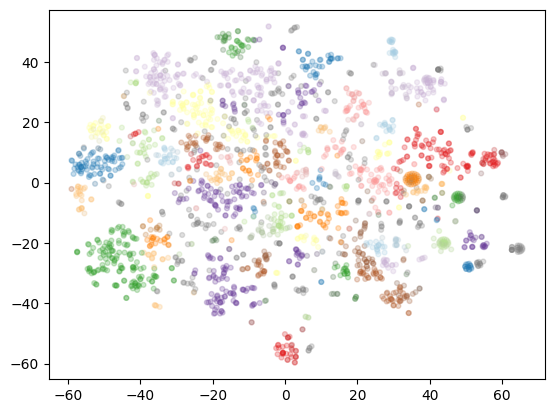

In [9]:
import hdbscan
import seaborn as sns

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=15, 
    min_samples=1,
    cluster_selection_epsilon=0.3,
).fit(embeddings_umap)

color_palette = sns.color_palette("Paired", n_colors=len(set(clusterer.labels_))) 
cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in zip(cluster_colors, clusterer.probabilities_)]

plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=cluster_member_colors, alpha=0.25, s=12);

In [10]:
import plotly.express as px

fig = px.scatter(
    x=embeddings_tsne[:, 0],
    y=embeddings_tsne[:, 1],
    color=clusterer.labels_.astype(str),
)

fig.show()
fig.write_html(root / "outputs" / "hdbscan_clusters.html")

In [11]:
import json
from collections import defaultdict

clusters_dict = defaultdict(list)

for idx, (label, probability) in enumerate(zip(clusterer.labels_, clusterer.probabilities_)):
    example_data = {
        "example_id": idx,
        "text": df.iloc[idx]['text'], 
        "probability": float(probability)
    }
    
    clusters_dict[str(label)].append(example_data)

output_file = root / "outputs" / "clustered_examples.json"
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(dict(clusters_dict), f, indent=2, ensure_ascii=False)